<a href="https://colab.research.google.com/github/raaraya1/Personal-Proyects/blob/main/Cursos/Fastai/Notas_de_la_clase9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clase 9 - Deep Learning for Coders**

# **Respuestas al cuestionario**

**1. Si el conjunto de datos de su proyecto llegará a ser muy grande y complejo de trabajar (con él lleva una cantidad significativa de tiempo) ¿qué debe hacer?**

A lo largo del curso, hemos visto varias opciones que podriamos aplicar. Por ejemplo reducir el batch size o utilizar el metodo `to_fp16`. Sin embargo, y conforme a lo visto en la clase, seria recomendable armar un nuevo conjunto de datos (con el cual sea mas sencillo de trabajar) y luego de asegurar que este funcione correctamente, aventurarse a trabajar con el set de datos mas complejo.


**2. ¿Por qué concatenamos los documentos en nuestro conjunto de datos antes de crear un modelo de lenguaje?**

Esto lo hacemos, principalmente, para generar un diccionario completo. Sucede que si no lo hacemos asi, podriamos comenter el error de presentar una palabra nueva en el conjunto de validacion, con lo cual, no se encontraria considerada en la matriz de embedding y como consecuencia, el modelo no tendria forma de generar alguna interpretacion sobre esta.

**3. Para usar una red estándar completamente conectada para predecir la cuarta palabra dadas las tres palabras anteriores, ¿Cuales son las 2 cosas que necesitamos hacer en nuestro modelo?**

1. Que la primera capa utilice los embeddings de la primera palabra como sus activaciones, luego que la segunda capa utilice el embedding de la segunda palabra y las activaciones de la primera (se suman), luego que en la tercera capa se ocupe los embeddings de la tercera palabra y se sumen las activaciones de la segunda capa (tambien se suman).

2. La segunda cosa que es necesaria, es que la matriz de embeddings que se utiliza en las palabras sea la misma. Esto es asi, para que los parametros de la matriz no cambien mientras nos vamos desplazando por las capas (no hace sentido que estos valores vayan cambiando por capas, pero si que podrian cambiar por epoch)


**4. ¿Cómo podemos compartir una matriz de peso en varias capas en PyTorch?**

Tenemos que repetir esta matriz cada vez que la queramos usar (cada vez que integramos una nueva palabra de la secuencia al modelo)

Mirando el modelo, esto hace referencia a la capa `self.i_h`


**5. Escribe un módulo que prediga la tercera palabra dadas las dos palabras anteriores de una oración, sin mirar.**

```python
# Como tengo que utilzar las dos palabras anteriores para predecir la tercera, 
# voy a tener que realzar algunos cambios antes

# Preparativos
path = untar_data(URLs.HUMAN_NUMBERS)
Path.BASE_PATH = path
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
text = ' . '.join([l.strip() for l in lines])
tokens = text.split(' ')
vocab = L(*tokens).unique()
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)

## Aqui realizamos un cambio (cambiamos 3 por 2)
seqs = L((tensor(nums[i:i+2]), nums[i+2]) for i in range(0,len(nums)-3,2))

# Luego, continueamos normal (recordar agregar el drop_last)
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False, drop_last=True)

# Luego definimos el modulo 
## Por ahora, no le voy a hacer todos los arreglos que vimos en la clase
class model(Module):
  def __init__(self, bs, vocab):
    self.input_layer = nn.Embedding(vocab, bs)
    self.midle_layer = nn.Linear(bs, bs)
    self.output_layer = nn.Linear(bs, vocab)
    self.h = 0

  def forward(self, x):
    word1 = self.input_layer(x[:, 0])
    self.h = self.h + word1
    self.h = self.midle_layer(self.h)
    self.h = torch.relu(self.h)
    word2 = self.input_layer(x[:, 1])
    self.h = self.h + word2
    out = self.output_layer(self.h)
    self.h = self.h.detach()
    return out
  
  def reset(self): 
    self.h = 0

# Cargamos un Batch y observamos como este sale del modelo
x = dls.train.one_batch()
input = x[0]
modelo = model(64, len(vocab))
salida = modelo.forward(input)
print(salida.shape )
>> torch.Size([64, 30])

# Luego lo cargamos a un learner
learn = Learner(dls, model(64, len(vocab)), loss_func=F.cross_entropy, 
                metrics=accuracy)
lr = learn.lr_find()[0]
learn.fit_one_cycle(4, lr)
>> 
epoch	train_loss	valid_loss	accuracy	time
  0	  1.324382	  2.229915	  0.452168	00:03
  1	  1.188938	  2.135392	  0.500638	00:03
  2	  1.087693	  2.121493	  0.509726	00:03
  3	  1.238023	  1.665929	  0.506059	00:03
```

**6. ¿Qué es una red neuronal recurrente?**

Es una red neuronal que utiliza ciclos (volviendo a ocupar sus capas), en lugar de utilizar capas nuevas.

**7. ¿Qué es el "Hidden State"?**

Son las activaciones (neuronas) que se van actualizando en cada paso de la red neuronal. (distinto a por ejemplo de as matriz de embedding, que se actualiza por epoch)

**8. ¿Cuál es el equivalente al 'Hidden State' en 'LMModel1'?**

Este es el modelo 'LMModel1'.

```python
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = F.relu(self.h_h(self.i_h(x[:,0])))
        h = h + self.i_h(x[:,1])
        h = F.relu(self.h_h(h))
        h = h + self.i_h(x[:,2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)
```

De esta manera, el 'Hidden State' son los parametros que se van guardando en h.

**9. Para mantener el estado en una RNN, ¿por qué es importante pasar el texto al modelo en orden?**

Esto se hace asi, porque la idea es que el modelo, aparte de predecir una palabra, reconozca la estructura y efectue una prediccion en base a esta. POr esto no sirve entregar los datos con un `shuffle`, sino que estos hay que entregarlos en secuencias.

**10. ¿Qué es una representación 'unrolled' de una RNN?**

Cuando armamos una RNN, existe una capa que utilizamos varias veces y esta solemos representarla como un ciclo. Sin embargo, en una representacion 'unrolled' lo que se hace es mostrar efectivamente todos los pasos que se resumen en ese ciclo. Para el caso de los modelos del lenguaje vistos en clase, se hace una representacion como si se tratara de una red neuronal profunda con una cantidad de capas ocultas igual al numero de palabras contenidos en las secuencias.

**11. ¿Por qué mantener el estado oculto en un RNN puede provocar problemas de memoria y rendimiento? ¿Cómo solucionamos este problema?**

Esto sucede porque a la hora de hacer el paso de backpropagation, se esta calculando las derivadas mirando todo el historial guardado en la capa oculta. Para evitar esto, tenemos que utilizar el metodo `detach` cuando se termine el recorrido de la red (al final del metodo `formward`).

**12. ¿Qué es "BPTT"?**

BPTT: Back Propagation Through Time. Realiza el metodo de backpropagation, pero todo lo que sucede en el metodo `forward` lo considera como una unica capa.

**13. Escriba código para imprimir los primeros batches del conjunto de validación, incluida la conversión de los ID del token a palabras en inglés, como mostramos para lotes de datos IMDb en chapter_nlp.**

```python
# Preparativos
path = untar_data(URLs.HUMAN_NUMBERS)
Path.BASE_PATH = path
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
text = ' . '.join([l.strip() for l in lines])
tokens = text.split(' ')
vocab = L(*tokens).unique()
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False, drop_last=True)

# Luego, para imprimir lo contenido en el conjunto de validacion
## Nota: para trabajar con un batch podemos usar dls.valid.one_batch()
validation_set = dls.valid.items
print(validation_set[:3])
>> [(tensor([ 1,  8, 29]), 26), 
(tensor([26,  5,  1]), 8), 
(tensor([ 8, 29, 26]), 6)]

validation_to_word = [([vocab[j] for j in i[0]], vocab[i[1]]) for i in validation_set]
print(validation_to_word[:3])
>> [(['.', 'eight', 'thousand'], 'eighty'),
 (['eighty', 'five', '.'], 'eight'),
 (['eight', 'thousand', 'eighty'], 'six')]
```

**14. ¿Qué hace `ModelResetter`? ¿Por qué lo necesitamos?**

Lo que hace es ejecutar la funcion `reset` contenida en la clase del modelo. Esto se hace necesario en caso de que nosotros queramos volver a entrenar la red neuronal, ya que asi nos aseguramos de partir con un hidden state limpio.

**15. ¿Cuáles son las desventajas de predecir una sola palabra de salida por cada tres palabras de entrada?**

La desventaja, es que no estamos aprovechando la oportunidad de utilizar todas las palabras para hacer predicciones sobre la siguiente. Es decir, podemos agregar mas 'señales' al modelo para que asi este tambien realice predicciones sobre la primera y segundo palabra. (De esta manera, entiende mejor la secuencia, porque se fija en mas palabras a la hora de efectuar las predicciones)

**16. ¿Por qué necesitamos una función de pérdida personalizada para `LMModel4`?**

Esta es la funcion de perdida que se personaliza.
```python
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))
```

Esto se hace asi, porque la salida de la red sale con una dimension adicional (producto del `stack`). Asi, con este metodo nos aseguramos que al calcular el error, se este trabajando bajo las mismas dimensiones.

**17. ¿Por qué es inestable el entrenamiento de "LMModel4"?**

En la clase se nos explica que este modelo tiene un funcionamiento mas complicado, lo cual resulta en ocaciones en la generacion de grandes y pequeños gradientes. Por eso, todo lo que resta del notebook son metodos para corregir estos gradientes (LSTM por ejemplo)

**18. En la representación desenrollada, podemos ver que una red neuronal recurrente en realidad tiene muchas capas. Entonces, ¿por qué necesitamos apilar RNN para obtener mejores resultados?**

En la clase no se especifica porque razon agregar mas capas de RNN ayuna a mejorar las predicciones (solo se intuye). Sin embargo, y mirando la estructura desenrollada, pareciera armarse un mini-modelo de red profunda para cada palabra nueva que ingresa.

**19. Dibuje una representación de un modelo RNN multicapa.**

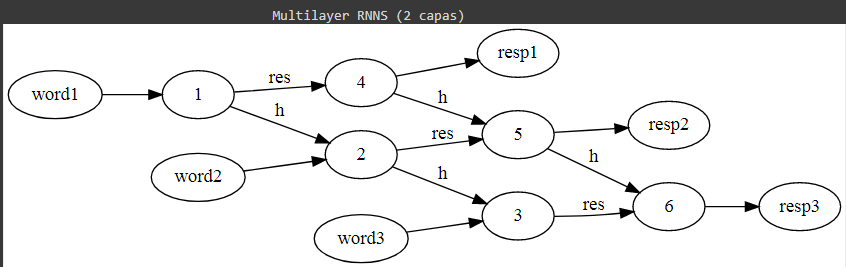

**20. ¿Por qué deberíamos obtener mejores resultados en un RNN si llamamos a `detach` con menos frecuencia? ¿Por qué no podría suceder esto en la práctica con un simple RNN?**

Si llamamos utilizamos el `detach` menos veces, lo que va a pasar es que vamos a ir guardando mayor infomacion en los hidden states (de hecho, sino lo llamamos para nada, se iran guardando las informaciones de todas las veces que ingresa una nueva palabra de la secuencia). La razon de porque no hacerlo en la practica, es por el out of memory y el numero de calculos que tendria que realizar el modelo (en otras palabras, tomaria mucho tiempo el entrenamiento)

**21. ¿Por qué una red profunda puede resultar en activaciones muy grandes o muy pequeñas? ¿Por qué importa esto?**

La razon de porque las activaciones pueden resultar muy grandes o pequeñas, es porque los valores entre capas se van multiplindo. Asi 2*2*2..., en unas pocas capas puede resultar en un numero bastante grandes, de la misma manera 0.1*0.1*0.1... tambien puede resultar en valores muy pequeños.

Importa, porque los computadores tienen cirtos limites al registrar los numeros. 

Por ejemplo, supongamos que el computador es capaz de registrar valores hasta 5 decimales y tenemos los siguientes numeros (muy chicos)

```python
valor1 = 0.000001
valor2 = 0.000002

# luego como el computador solo es capaz de rescatar valores hasta 5 decimales
# esta seria la interpretacion de los numero que extrae
valor1 = 0.00000
valor2 = 0.00000

# ahora, imaginemos por un momento que estos valores los dejamos de llamar valor 1 y valor 2, y los empezamos a llamar output y target. Aqui resulta facil notar que el metodo de backpropagation no sirve, puesto que no hay perdida (loss)
```

**22. En la representación de números de punto flotante de una computadora, ¿qué números son los más precisos?**

La forma en que los computadores guardan los numeros, es a lo que se refiere el termino 'floating point' y en particular estos se vuelven cada vez menos precisos a meidda que nos vamos alejando del 0. (en este sentido, en este sentido, seria bueno siempre buscar la alternativa de normalizan en funcion de 0)

**23. ¿Por qué los gradientes que desaparecen impiden el entrenamiento?**

Esto es asi, porque el metodo de SGD requiere algun valor de perdida, pero si no le entregamos nada, entonces el modelo se encontrara estancado en el entrenamiento (con un gradiente cero, todos las activaciones de las capas quedaran igual)

**24. ¿Por qué ayuda tener dos estados ocultos en la arquitectura LSTM? ¿Cuál es el propósito de cada uno?**

- cell state: Ayuda a memorizar todo lo que va sucediendo al ir recorriendo la oracion.

- hidden state: Esta se focaliza en predecir la siguiente palabra (para esto deben trabajar con la infomacion correcta)

**25. ¿Cómo se llaman estos dos estados en un LSTM?**

cell state ($c_{t}$) y hidden state ($h_{t}$)

**26. ¿Qué es tanh y cómo se relaciona con el sigmoide?**

\begin{equation}
tanh(x) = \frac{senh(x)}{cosh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} = 2\sigma(2x)-1
\end{equation}

**27. ¿Cuál es el propósito de este código en `LSTMCell`:` h = torch.cat ([h, input], dim = 1) `**

Esto es para juntar el $x_{t}$ con el $h_{t-1}$, ya que esta es la manera en que van entrando por las puertas.

**28. ¿Qué hace `chunk` en PyTorch?**

Diveide en partes iguales un tensor. (divide el tensor ordenadamente, de manera de generar nuevos tensores con la misma cantidad de elementos)

**29. Estudie la versión refactorizada de `LSTMCell` cuidadosamente para asegurarse de que comprende cómo y por qué hace lo mismo que la versión no refactorizada.**

**Version original**
```python
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)

    def forward(self, input, state):
        h,c = state
        h = torch.cat([h, input], dim=1)
        forget = torch.sigmoid(self.forget_gate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = out * torch.tanh(c)
        return h, (h,c)
```

**Version refactorizada**

```python
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni,4*nh)
        self.hh = nn.Linear(nh,4*nh)

    def forward(self, input, state):
        h,c = state
        # juntamos x(t) con h(t-1)
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        # calculamos todas las salidas con la funcion sigmoide
        ingate,forgetgate,outgate = map(torch.sigmoid, gates[:3])
        # La ultima la usamos on  tanh()
        cellgate = gates[3].tanh()

        # generamos el recorrido de arriba (lo que se va recordando)
        c = (forgetgate*c) + (ingate*cellgate)
        # generamos el recorrido del final (lo que se predice)
        h = outgate * c.tanh()
        return h, (h,c)
```


**30. ¿Por qué podemos utilizar una tasa de aprendizaje más alta para "LMModel6"?**

En la clase no se da una razon explicita de porque se puede utilizar un LR mas alto, aunque intuyo que, gracias a la LSTM, vamos a tener mas 'controlados' los valores de las activaciones, de manera que se flexibilizaria la limitante de trabajar con LR bajo en funncion de evitar el fenomeno de 'Exploding'

**31. ¿Cuáles son las tres técnicas de regularización que se utilizan en un modelo AWD-LSTM?**

1. Dropout
2. Activation Regularization
3. Temporal Activation Regularization

**32. ¿Qué es la "Dropout"?**

Este metodo consiste en desactivar, de manera aleatoria, algunas de las activaciones de la red, mientras esta se encuentra entrenando.

Lo otro que se tiene que hacer, es rescalar la salida (es por esta razon que se divide por (1-p), siendo p la probabilidad de desactivar una neurona condsiderando una distribucion bernoulli)

**33. ¿Por qué escalamos las actividades con el dropout? ¿Se aplica esto durante el entrenamiento, la inferencia o ambos?**

Miremos la siguiente situacion.

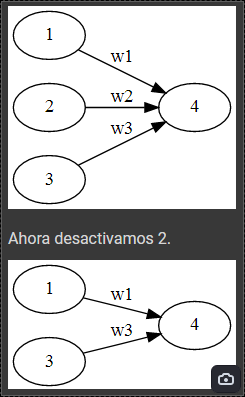

Si antes de desactivar, teniamos que 4 que valdria $w_{1} + w_{2} + w_{3}$, en la segunda imagen pasa a valer $w_{1} + w_{3}$. Esto es un problema, porque al quitar activaciones cambiará los valores que normalmente esperariamos obtener en las activaciones siguientes. De esta manera, aqui la palabra clave es **esperar**, puesto que al repetir esto un alto numero de veces (y recordando que la probabilidad de activacion es de (1-p)) nos encontraremos con la siguiente figura.

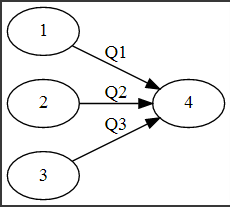

Siendo los valores $Q_{1} = w_{1}(1-p), Q_{2} = w_{2}(1-p), Q_{3} = w_{3}(1-p)$.

Asi el valor esperado en 4 seria.

$E(4) = Q_{1} + Q_{2} + Q_{3} = w_{1}(1-p) + w_{2}(1-p) + w_{3}(1-p) = (1-p)(w_{1} + w_{2} + w_{3})$

Luego, si queremos que este valor esperado se ajuste con los valores que obteniamos al inicio (sin la utilizacion de dropout), tenemos que dividir por (1-p).

Por ultimo, y en relacion a cuando ocupamos el dropout, este lo hacemos solo en el entrenamiento (para eso tenemos que decirle al programa con el metodo `train` activado)

**34. ¿Cuál es el propósito de esta línea de `Dropout`:` if not self.training: return x`**

Esta linea esta pensada justamente para cuando realicemos inferencias, ya lo que hace es verificar si estamos entrenando y en el caso de que no, obviara el proceso de desactivar las neuronas.

**35. Experimente con `bernoulli_` para entender cómo funciona.**

La experimentacion se encuetra mas abajo.

**36. ¿Cómo configura su modelo en modo de entrenamiento en PyTorch? ¿En modo de evaluación?**

Llamando con el metodo `train` se deja como `True` el parametro `training`. Por el contrario, con el metodo `eval` se deja al parametro `training` en `False`.

**37. Escriba la ecuación para la regularización de la activación (en matemáticas o código, como prefiera). ¿En qué se diferencia de la pérdida de peso?**

\begin{equation}
loss = loss + \alpha \frac{\sum_{i=1}^{len(vocab)} n_{ho}^2}{len(vocab)}
\end{equation}

```python
loss += alpha * activations.pow(2).mean()
```

La diferencia con weight decay (como su nombre lo indica), es que este utiliza los pesos en lugar de las activaciones.

**38. Escriba la ecuación para la regularización de la activación temporal (en matemáticas o código, como prefiera). ¿Por qué no usaríamos esto para problemas de visión por computadora?**

\begin{equation}
loss = loss + \beta \frac{\sum_{i=1}^{n_{capas}}\sum_{j=1}^{seqc-1} (n_{i, j+1}-n_{i, j})^2}{n_{capas}*(seqc-1)}
\end{equation}

```python
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```

En la clase no se dice explicitamente porque no utilizarlo, sin embargo, el metodo TAR, esta mas orientado a penalizar en el loss si las predicciones no se siñen a una secuencia de palabras. De esta manera, creo que si utilizaramos este metodo para imagenes, estariamos incrementando la funcion de perdida innesesariamente, ya que de antemano, no tenemos una secuencia u orden que respetar (en este caso un ordenamiento entre pixeles) 

**39. ¿Qué es "weight tying" en un modelo de lenguaje?**

Lo que se hace es ir cambiando los pesos de salida que convierten las activaciones de la ultima capa a palabras. Asi utilizamos los mismo pesos de la matriz de embedding, teniendo presente que esta tiene el trabajo justo a la inversa, es decir, transformar de palabras a activaciones.

```python
self.h_o.weight = self.i_h.weight
```

# **A language model from scratch**

In [ ]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 1.2 MB 31.3 MB/s 
     |████████████████████████████████| 186 kB 43.1 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 280 kB/s 


## **The Data**

En esta ocación los datos corresponden a numeros escritos. Asi, este modelo de lenguaje recibira una gran cantidad de numeros escritos y tratará de predecir el siguiente.


In [ ]:
# Importamos los datos (esta base de datos fue generada por fastai)
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [ ]:
Path.BASE_PATH = path

In [ ]:
# miramos el contenido del archivo
path.ls()

(#2) [Path('valid.txt'),Path('train.txt')]

In [ ]:
# sumamos los conjuntos de entrenamiento y validacion
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [ ]:
# ahora generamos una secuencia y separamos por un punto (ojo, incluye espacios)
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [ ]:
# aqui separameos por espacios
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [ ]:
# guardamos todos los valres unicos
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [ ]:
# por ultimo, generamos el diccionario
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

## **Our First Language Model from Scratch**

In [ ]:
# vamos a hacer una secuencia de tres tokens, con el objetivo de predecir el cuarto
L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [ ]:
# Lo mismo, pero en numero (esto es lo que en realidad entra al modelo)
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [ ]:
# Por ultimo, definimos los valores del batch size y el tamaño de los conjunto de 
# entrenamiento y validacion (80% entrenamiento y 20% validacion)
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

In [ ]:
# Aqui esta, por ejemplo, el primer elemento del batch (input, target)
x, y = dls.train.one_batch()
x[0], y[0]

(tensor([0, 1, 2]), tensor(1))

### **Our Language Model in PyTorch**

El modelo que se contruye a continuacion, tiene la particularidad que la matriz del Embadding no cambia en el recorrido de la red.

La manera en como se va recorriendo la red (y en particular para este ejercicio con 3 palabras de input y una de output) es la siguiente.



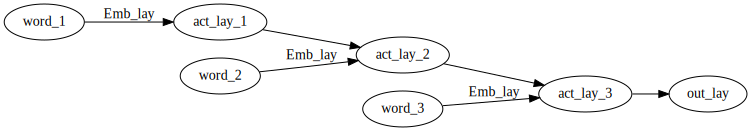

In [ ]:
# Representacion del modelo
gv('''word_1->act_lay_1[label=Emb_lay];
      act_lay_1->act_lay_2;
      word_2->act_lay_2[label=Emb_lay]
      act_lay_2->act_lay_3;
      word_3->act_lay_3[label=Emb_lay];
      act_lay_3->out_lay
      ''')

In [ ]:
# ahora vamos a construir esta estructura
# Recordar ocultar los print, para cuando se utilice el modelo para entrenar
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        #print(f' 1) usamos la primera dimension del batch (la primera palabra) ({x[:, 0].shape}) \n {x[:, 0]}')
        h = F.relu(self.h_h(self.i_h(x[:,0])))
        #print(f'\n2) asi resulta su embedding ({self.i_h(x[:,0]).shape}) \n {self.i_h(x[:,0])}')
        #print(f'\n3) luego lo hacemos pasar por la capa lineal ({self.h_h(self.i_h(x[:,0])).shape}) \n {self.h_h(self.i_h(x[:,0]))} ')
        #print(f'\n4) luego aplicamos la funcion de activacion (ReLU) ({h.shape}) \n {h}')
        h = h + self.i_h(x[:,1])
        #print(f'\n5) ahora usamos la segunda dimension del batch (segunda palabra) ({x[:, 1].shape}) \n {x[:, 1]}')
        #print(f'\n6) le aplicamos el embedding ({self.i_h(x[:,1]).shape}) \n {self.i_h(x[:,1])}')
        #print(f'\n7) ahora sumamos las activaciones anteriores con el ebedding(segunda palabra) ({h.shape}) \n {h}')
        h = F.relu(self.h_h(h))
        #print(f'\n8) luego aplicamos la funcion de activacion (ReLU) ({h.shape}) \n {h}')
        h = h + self.i_h(x[:,2])
        #print(f'\n9) ahora usamos la tercera dimension del batch (tercera palabra) ({x[:, 2].shape}) \n {x[:, 2]}')
        #print(f'\n10) le aplicamos el embedding ({self.i_h(x[:,2]).shape}) \n {self.i_h(x[:,2])}')
        #print(f'\n11) ahora sumamos las activaciones anteriores con el ebedding(segunda palabra) ({h.shape}) \n {h}')        
        h = F.relu(self.h_h(h))
        #print(f'\n12) luego aplicamos la funcion de activacion (ReLU) ({h.shape}) \n {h}')
        #print(f'\n13) por ultimo le aplicamos una capa lineal a la salida ({self.h_o(h).shape}) \n {self.h_o(h)}')
        return self.h_o(h)

In [ ]:
# Veamos la entrada, el recorrido y la salida
# batch1 palabra1
print(x[0, 1].shape)
# batch con todas las palabras 1
print(x[:, 0].shape)
# batch con todas las palabras 2
print(x[:, 1].shape)
# batch con todas las palabras 3
print(x[:, 2].shape)

# el tensor que entra al modelo
print(x.shape)

torch.Size([])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 3])


In [ ]:
# veamos el recorrido (en esta parte voy a activar los print comentados arriba)
modelo = LMModel1(len(vocab), 64)
modelo.forward(x)

tensor([[-0.1132, -0.4100, -0.2762,  ..., -0.0883, -0.2911, -0.0709],
        [-0.1540,  0.0603,  0.0940,  ...,  0.0830, -0.5265, -0.6186],
        [ 0.1819, -0.1436,  0.0520,  ...,  0.3193, -0.3657,  0.1965],
        ...,
        [ 0.4798, -0.1558, -0.3993,  ...,  0.2716, -0.4619,  0.4034],
        [ 0.5655, -0.1392, -0.4306,  ...,  0.2195, -0.5167,  0.4027],
        [ 0.4212, -0.0585, -0.3862,  ...,  0.2385, -0.4919,  0.4068]], grad_fn=<AddmmBackward>)

**Importante**: Si bien en el anterior recorrido no se observa la matriz de Embedding, si es posible verificar que, en todo momento el token 1 ('.') termina con el tensor `[ 0.1100,  2.4751,  0.7828,  ..., -0.5626, -1.1394, -0.8253]`. Esto quiere decir que se utilizo la misma matriz en todo el recorrido.

In [ ]:
# Ahora que ya sabemos como se trabajan los datos, falta denefir la funcion de perdida
## Recordemos que cross entropy es ideal para trabajar con categorias
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.854007,1.978972,0.462325,00:02
1,1.394722,1.792281,0.480152,00:02
2,1.403728,1.669184,0.488947,00:02
3,1.373266,1.684499,0.435702,00:02


In [ ]:
# Todo va bien, pero ¿como sabemos si el resultado anterior es bueno o malo?
## Para responder a esta pregunta, armemos un modelo sencillo con el cual comparar
### Lo que se hace a continuacion es obtener la palabra que mas se repite y utilizarla
### como la prediccion para todo el conjunto de validacion
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): 
      counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(29), 'thousand', 0.15165200855716662)

#### **Escrito de otra forma**

In [ ]:
# sacar los target del conjunto de validacion
valores_y = []
for x, y in dls.valid:
  for element in y:
    valores_y.append(element.item())
    
print(len(valores_y))

4207


In [ ]:
# ahora voy a contar
contador = np.zeros(len(vocab)) # son 30 numeros distintos
for valor in valores_y:
  contador[valor] += 1
print(np.argmax(contador))
print(np.max(contador)/len(valores_y))

# Lo que nos dice este 0.15 es que si utilizamos el token 29 como prediccion sobre 
# todo el conjunto de validacion, entonces acertaremos el 15% de las veces
## Notar que este valor es bastante menor al 0.49 obtenido del modelo de red neuronal

29
0.15165200855716662


### **Our First Recurrent Neural Network**

In [ ]:
# Lo que vamos a hacer ahora es reescribir el modelo anterior, pero
# acortando con un ciclo for
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [ ]:
# Verifiquemos obtener resultados similares
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.875688,1.921878,0.463513,00:02
1,1.397101,1.767072,0.468980,00:02
2,1.397369,1.639939,0.492988,00:02
3,1.354895,1.623882,0.491799,00:02


## **Improving the RNN**

### **Maintaining the State of an RNN**

Problema:
- Al colocar el `self.h=0` en el metodo forward, estamos empezando con una 'hoja en blanco', cuando podriamos hacer uso de los pesos guardados de una secuencia anterior.

Solucion:
- Colocar el `self.h` como una de los atributos de la clase (`__init__`).

Subproblema:
- Lo malo con esta medida es que, por asi decirlo, transforma nuestra red neuronal en una similar a una deep neuronal network con 10.000 capas (una por cada token). Asi, cuando analizemos los tokens de las ultimas secuencias, tendremos que calcular las derivadas desde el final hasta la primera capa.

Solucion:
- Utilizar el metodo `detach` para borrar el historial de gradientes y asi solo conservar el de las ultimas tres capas.

**Nota**: Este metodo es llamado 'back propagation through time' (Realiza el metodo de back propagation, pero simulando que cada recursion como una unica capa). Tambien hay que tener ojo que este metodo es valido para un dataset en el que se pueda observar el 'flujo de texto' entre los batches (no vale desordenar los batches, tienen que estar ordenados para darle la logica al texto)

In [ ]:
# Justamente lo que se hace aqui es arreglar los problemas antes mencionados
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [ ]:
# Lo que vamos a hacer aqui es construir el metodo por el cual fastai ordena los
# batches
m = len(seqs)//bs
m,bs,len(seqs)

# (cantidad de grupos, cantidad de tokes por grupos, cantidad total de tokens)

(328, 64, 21031)

In [ ]:
# Aqui generamos la funcion para generar estos grupos
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): 
      new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [ ]:
# Probemosla para un batch size cualquiera
bs = 4
lista = group_chunks(seqs, bs)
for i in range(10):
  fila = [(vocab[lista[i + bs*j][0]], vocab[lista[i + bs*j][1]]) for j in range(bs)]
  print(fila)  

# Aqui podemos observar el ordenamiento

[(['one', '.', 'two'], '.'), (['.', 'three', '.'], 'four'), (['four', '.', 'five'], '.'), (['.', 'six', '.'], 'seven')]
[(['nine', '.', 'two'], 'thousand'), (['thousand', 'seven', 'hundred'], 'forty'), (['forty', '.', 'two'], 'thousand'), (['thousand', 'seven', 'hundred'], 'forty')]
[(['hundred', 'seventy', 'eight'], '.'), (['.', 'five', 'thousand'], 'one'), (['one', 'hundred', 'seventy'], 'nine'), (['nine', '.', 'five'], 'thousand')]
[(['thousand', 'five', 'hundred'], 'eighty'), (['eighty', 'eight', '.'], 'seven'), (['seven', 'thousand', 'five'], 'hundred'), (['hundred', 'eighty', 'nine'], '.')]
[(['.', 'three', '.'], 'four'), (['four', '.', 'five'], '.'), (['.', 'six', '.'], 'seven'), (['seven', '.', 'eight'], '.')]
[(['thousand', 'seven', 'hundred'], 'forty'), (['forty', '.', 'two'], 'thousand'), (['thousand', 'seven', 'hundred'], 'forty'), (['forty', 'one', '.'], 'two')]
[(['.', 'five', 'thousand'], 'one'), (['one', 'hundred', 'seventy'], 'nine'), (['nine', '.', 'five'], 'thousand'

In [ ]:
# Debidimos el conjunto de entrenamiento y el de validacion (80 y 20)
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

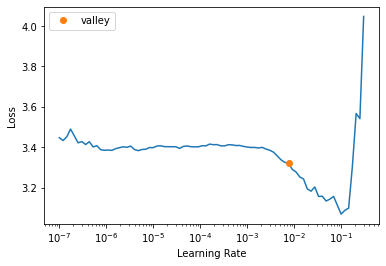

In [ ]:
# por ultimo, volvemos a entrenar
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
lr = learn.lr_find()[0]

In [ ]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.023762,2.149230,0.424834,00:32
1,1.183364,3.230545,0.352046,00:32
2,1.626408,2.985545,0.265224,00:32
3,1.769459,2.469400,0.360133,00:32
4,1.713362,2.523513,0.262607,00:32
5,1.460294,2.798985,0.295671,00:32
6,1.445482,2.278750,0.295671,00:32
7,1.394172,2.185858,0.394624,00:32
8,1.554979,2.281764,0.400571,00:33
9,1.876936,2.076117,0.431732,00:33


#### **Prediccion Manual**

No me resulto el metodo tradicional para predecir con fastai, asi que lo hice mas o menos a mano.

**Nota:** No consegui obtener los mismos resultados del accuracy.

In [ ]:
x, y = dls.valid.one_batch()
tensor_prueba = x[0]
tensor_prueba = tensor_prueba.unsqueeze(0)
tensor_prueba.shape

torch.Size([1, 3])

In [ ]:
prediccion = learn.model.forward(tensor_prueba)
prediccion.shape

torch.Size([1, 30])

In [ ]:
# Por ultimo, lo tengo que hacer es hacerlo pasar por la funcion softmax
#funcion_salida = F.softmax
#prediccion = funcion_salida(prediccion)
prediccion = torch.argmax(prediccion)
prediccion = vocab[prediccion]
prediccion

'eight'

In [ ]:
# este es el valor esperado (no acerto)
vocab[y[0]]

'eighty'

In [ ]:
funcion_salida = F.log_softmax


In [ ]:
def predict(tensor_prueba, num=False):
  tensor_prueba = tensor_prueba.unsqueeze(0)
  prediccion = learn.model.forward(tensor_prueba)
  prediccion = funcion_salida(prediccion, dim=1)
  prediccion = torch.argmax(prediccion)
  if num == False:
    prediccion = vocab[prediccion]
  return prediccion

In [ ]:
# para este caso si acerto
tensor_prueba = x[2]
valor_esperado = vocab[y[2]]
valor_predicho = predict(tensor_prueba)
print(f'tensor de entrada: {vocab[tensor_prueba]}')
print(f'valor esperado: {valor_esperado}')
print(f'valor predicho: {valor_predicho}')

tensor de entrada: ['thousand', 'forty', 'three']
valor esperado: .
valor predicho: .


In [ ]:
# por ultimo, y solo para corroborar que la funcion de prediccion esta funcionando
# bien, lo que hare sera calcular el accuracy para el set de validacion (este deberia
# calzar con el obtenido en el ultimo epoch del entrenamiento)

# Aqui obtenemos todos los valores del conjunto de entrenamiento y los separamos 
# en x = inputs e y = target
x = [dls.valid.items[i][0] for i in range(len(dls.valid.items))]
y = [dls.valid.items[i][1] for i in range(len(dls.valid.items))]

aciertos = 0
for i in range(len(y)):
  pred = predict(x[i], num=True)
  target = y[i]
  if pred == target:
    aciertos += 1

aciertos/len(y)
## Curioso, no obtuve los mismo resultados al ultimo epoch en el accuracy
## No me acuerdo si fastai utiliza todo el conjunto de validacion, o solo una muestra
## Quiza la diferencia vaya por ahi.

0.36988582302568984

### **Creating More Signal**

Lo que vamos a hacer ahora es:

1. Dejar la extension de la secuencia varaibles (se cambia de 3 a 16)
2. Cambiar un poco la architectura del modelo. Ahora en lugar de recibir un solo valor de salida, se tiene un tensor de salida. Para esto, cambiamos el target con una cantidad de tokens igual al que tiene el input.

In [ ]:
# sl -> Sequence Lengh (es esta ocacion lo ajustamos a 16)
## hacemos la siguiente separacion (ejemplo)
## input -> (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
## target-> (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)

sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [ ]:
# Asi queda
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [ ]:
# Agregamos unas pequeñas variaciones al modelo
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []  # Aqui agregamos una lista para ir guardando las salidas
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1) # Aqui transformamos esta lista en tensor
    
    def reset(self): self.h = 0

In [ ]:
# Tenemos que cambiar la funcion de salida
# tenemos que dejar, tanto la salida del modelo como el target en un formato similar
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

epoch,train_loss,valid_loss,accuracy,time
0,3.358870,3.277323,0.132324,00:01
1,2.775333,2.100921,0.435384,00:00
2,1.967965,1.870205,0.449382,00:01
3,1.595540,1.804942,0.478923,00:00
4,1.372554,1.744057,0.522786,00:01
5,1.229306,1.749440,0.548096,00:01
6,1.119603,1.756930,0.548177,00:00
7,1.040872,1.639826,0.564209,00:00
8,0.967316,1.668041,0.573079,00:01
9,0.925106,1.667412,0.579753,00:01


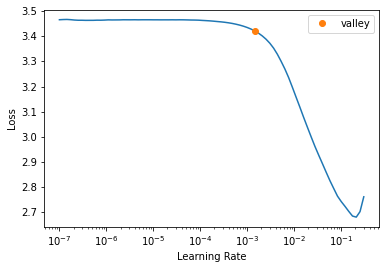

In [ ]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
lr = learn.lr_find()[0]
learn.fit_one_cycle(15, lr)

#### **Predicciones a mano**

Me volvio a suceder que los aciertos en las predicciones no me calzan con los obtenidos del entrenamiento, aunque si se pudo observar una mejora en relacion a los calculados a mano del paso anterior.

In [ ]:
valid_set = learn.dls.valid.items
valid_set[0]

(tensor([29, 26,  3,  1,  8, 29, 26,  4,  1,  8, 29, 26,  5,  1,  8, 29]),
 tensor([26,  3,  1,  8, 29, 26,  4,  1,  8, 29, 26,  5,  1,  8, 29, 26]))

In [ ]:
total = len(valid_set)
x = [valid_set[i][0] for i in range(total)]
y = [valid_set[i][1] for i in range(total)]
x[0]

tensor([29, 26,  3,  1,  8, 29, 26,  4,  1,  8, 29, 26,  5,  1,  8, 29])

In [ ]:
funcion_salida = F.softmax

In [ ]:
tensor_prueba = x[0].unsqueeze(0)
res = learn.model.forward(tensor_prueba)
res = torch.argmax(res, dim=2)
res.shape

torch.Size([1, 16])

In [ ]:
def new_predict(tensor_prueba, num=False):
  tensor_prueba = tensor_prueba.unsqueeze(0)
  prediccion = learn.model.forward(tensor_prueba)
  prediccion = funcion_salida(prediccion, dim=2)
  prediccion = torch.argmax(prediccion, dim=2)
  prediccion = prediccion.view(-1)
  if num == False:
    prediccion = vocab[prediccion]
  return prediccion[-1]


In [ ]:
aciertos = 0
for i in range(total):
  pred = new_predict(x[i], num=True)
  target = y[i][-1]
  #print(f'prediccion: {pred}')
  #print(f'target: {target}')
  if pred == target:
    aciertos += 1
aciertos/len(y)

0.5065104166666666

## **Multilayer RNNs**

La forma en la que estas trabajan es utilizando la salida de una RNN para alimentar a otra RNN.

Mas abajo, puede quedar mas claro los avances que hemos realizado hasta el momento.

                                   RNN (1 signal)


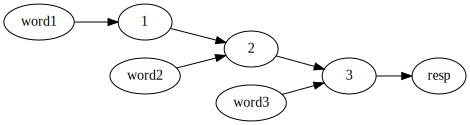

In [ ]:
print('                                   RNN (1 signal)')
gv('''word1 -> 1;
      word2 -> 2;
      word3 -> 3;
      1 -> 2;
      2 -> 3;
      3 -> resp''')


                                   RNN (3 signals)


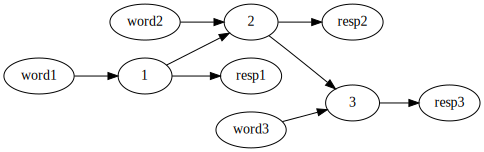

In [ ]:
print('                                   RNN (3 signals)')
gv('''word1 -> 1; word2 -> 2; word3 -> 3; 1 -> 2;
      2 -> 3; 1 -> resp1; 2 -> resp2; 3 -> resp3''')


                                   Multilayer RNNS (2 capas)


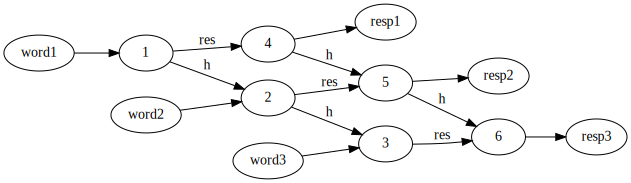

In [ ]:
# Aqui podemos notar que agregamos una capa adicional (4, 5, 6)
print('                                   Multilayer RNNS (2 capas)')
gv('''word1 -> 1; word2 -> 2; word3 -> 3; 1 -> 2[label=h];
      2 -> 3[label=h]; 1 -> 4[label=res]; 2 -> 5[label=res]; 3 -> 6[label=res]; 4 -> 5[label=h];
      5 -> 6[label=h]; 4 -> resp1; 5 -> resp2; 6 -> resp3''')

### **The Model**

In [ ]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True) # podemos resumir una RNN con esta funcion
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        # aqui obtenemos lo necesario para la otra capa (h y res(esta actua como la nueva palabra de entrada))
        # en el dibujo de arriba puede quedar mas claro (notar que en 1 y 4, h se comienza con 0)
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

epoch,train_loss,valid_loss,accuracy,time
0,3.042007,2.699477,0.394043,00:01
1,2.161693,1.804153,0.471029,00:01
2,1.709983,1.789562,0.405192,00:01
3,1.467983,1.722651,0.486979,00:01
4,1.269960,1.956122,0.485026,00:01
5,1.068349,1.800050,0.489827,00:01
6,0.885207,1.979312,0.511963,00:01
7,0.736110,2.122348,0.519368,00:01
8,0.612796,2.255913,0.528158,00:01
9,0.521253,2.341738,0.536051,00:01


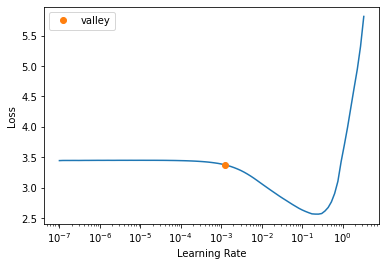

In [ ]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), # el 2, hacer referencia a utilizar 2 capas RNN
                loss_func=CrossEntropyLossFlat(), # Esto es equivalente a la funcion de perdida anterior
                metrics=accuracy, cbs=ModelResetter)
lr = learn.lr_find()[0]
learn.fit_one_cycle(15, 3e-3)

### **Exploding or Disappearing Activations**

Sorpresivamente, este modelo arrojo un peor desempeño, y la razon se esconde en este concepto de Exploding y Disappearing Activations.

Sin entrar mucho en detalles sobre las matematicas, el problema surge de calcular las derivadas de los parametros de las primeras capas. Asi, estos se actualizaban efectuando derivadas parciales sobre la perdida del modelo, pero para realizar este calculo, nosotros antes debiamos calcular las derivadas parciales de las ultimas capas y luego, por regla de la cadena, ir desgranando y multiplicando. 

El problema entonces, se genera por esta multiplicacion de derivadas parciales, las cuales incrementan o reducen con facilidad el valor final de la cadena que tengo que calcular. (recordando las primeras clases, ya sabemos el problema de presentar un gradiente 0 con el metodo de gradient descent)


## **LSTM**

Lo que vamos a hacer aqui es utilizar una estructura que vienen a arreglar el problema anterior, a estas estructuras se las llama LSTM (Long Short Term Memory)

Es un poco enredado el recorrido, por lo que voy a dejar la foto de como funcionan.

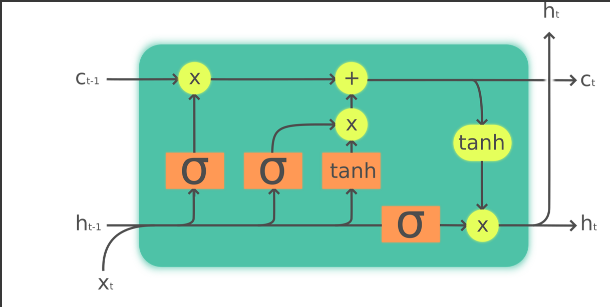

**Nota:** Existe otra estructura que tambien equivalente, las GRU (Gated Recurrent Units), sin embargo, no se profundizan en la clase.

### **Building an LSTM from Scratch**

In [ ]:
# Bien, aqui se encuentra el recorrido mostrado en la figura
## Si miramos la figura, en la parte de abajo a la izquierda se puede
## Observar como H y X se juntan y pasan por distintas 'Puertas' (4)
## Recorramoslas
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh) # Puerta 1
        self.input_gate  = nn.Linear(ni + nh, nh) # Puerta 2
        self.cell_gate   = nn.Linear(ni + nh, nh) # Puerta 3
        self.output_gate = nn.Linear(ni + nh, nh) # Puerta 4

    def forward(self, input, state):
        h,c = state # Entran H y C (X es el input)
        h = torch.cat([h, input], dim=1) # juntamos H y X
        forget = torch.sigmoid(self.forget_gate(h)) # Puerta 1, del olvido 
        c = c * forget # La resultante de la puerta 1, la multiplicamos por C
        inp = torch.sigmoid(self.input_gate(h)) # Puerta 2
        cell = torch.tanh(self.cell_gate(h)) # Puerta 3
        # Multiplicamos lo resultante de la puerta 2 con la 3 y sumamos C
        c = c + inp * cell
        # Por una parte sacamos C (nuevo), y por otra lo pasamos por tanh y multiplicamos 
        # por resultante de puerta 4 
        out = torch.sigmoid(self.output_gate(h))
        h = out * torch.tanh(c) # Aqui generamos el nuevo H
        return h, (h,c)

In [ ]:
# Mismo codigo anterior, pero realizando los calculos de manera matricial
## Asi, se ejecuta mas rapido
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni,4*nh)
        self.hh = nn.Linear(nh,4*nh)

    def forward(self, input, state):
        h,c = state
        # One big multiplication for all the gates is better than 4 smaller ones
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate,forgetgate,outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()

        c = (forgetgate*c) + (ingate*cellgate)
        h = outgate * c.tanh()
        return h, (h,c)

In [ ]:
t = torch.arange(0,10)
t

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Aqui podemos ver en accion la funcion chunk (separa el tensor en partes iguales)
t.chunk(2)

(tensor([0, 1, 2, 3, 4]), tensor([5, 6, 7, 8, 9]))

### **Training a Language Model Using LSTMs**


In [ ]:
# Aqui, reemplazamos las capas RNN por estas LSTM
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

epoch,train_loss,valid_loss,accuracy,time
0,3.017374,2.792713,0.239909,00:01
1,2.244353,1.723741,0.336589,00:01
2,1.632413,1.774232,0.433757,00:01
3,1.360035,1.803332,0.482178,00:01
4,1.144320,2.138382,0.493001,00:01
5,0.945287,1.843273,0.518880,00:01
6,0.747629,1.905661,0.559652,00:01
7,0.564484,1.655866,0.605143,00:01
8,0.428665,1.582678,0.667643,00:01
9,0.340310,1.641732,0.684896,00:01


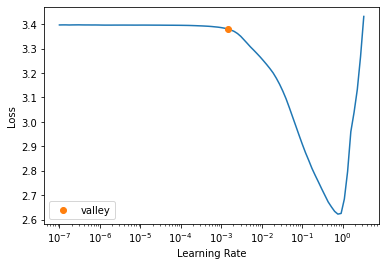

In [ ]:
# Volvemos a entrenar
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
lr = learn.lr_find()[0]
learn.fit_one_cycle(15, 1e-2)

## **Regularizing an LSTM**

Ya a partir de este momento, estamos consiguiendo un desempeño destacable con el modelo. Sin embargo, aun podemos agragar un par de tecnicas mas.

### **Dropout**

Con esta tecnica lo que se va haciendo es ir desactivando aleatoriamente algunas de las neuronas contenidas en las capas de la red neuronal. Para esto se utiliza el metodo de mas abajo, siendo el parametro p el utilizado para regular con que probabilidad se podra encontrar activa una neurona. (probabilidad p de que no se encuentre activa y (1-p) de que si este activa)

Nota: Este metodo se utiliza en los modelos de imagenes de Fastai y tambien se puede utilizar en los modelos tabulares, agregando el parametro `ps`.

In [ ]:
# Esta es la clase que se utiliza para ir desactivando las neuronas
## Notar que esto solo se esta aplicando en el entrenamiento
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

In [ ]:
# Probemos lo que hace el metodo bernoulli
p = 0.5
input = torch.rand(4)
prob = torch.clone(input).bernoulli_(1-p).div_(1-p)
res = input*prob
print(input)
print(prob)
print(res)

tensor([0.1994, 0.5472, 0.0062, 0.9516])
tensor([2., 0., 2., 0.])
tensor([0.3987, 0.0000, 0.0123, 0.0000])


### **Activation Regulazation and Temporal Activation Regularization**

Estos metodos funcionan bastante paracidos al 'weight decay', ya que en ambos se busca incrementar la funcion de perdida, para asi reducir el valor que pueden tomar las activaciones.

 - AR (Activation Regulazation): Se aplica solo a las activaciones del final.
```
loss += alpha * activations.pow(2).mean()
```
 - TAR (Temporal Activation Regularization): Se toma en consideracion, las activaciones las palabras anteriores (se excluye la del final, porque se calcula con el AR)   
```
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```
- Nota: Recordar que la estrucura del tensor es la siguiente. [batch size, secuence lenght, n_hidden]


### **Training a Weight-Tied Regularized LSTM**

In [ ]:
# Ahora para agregar el Dropout hacemos lo siguiente
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True) #, batch_first=True
        # Con esto, solo definimos la funcion, especificando el valor p
        self.drop = nn.Dropout(p)    
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h) # Raw es equivalente al Res 
        out = self.drop(raw) # Le aplicamos el drop a al Res
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out # Aqui la salida h_o(out), ya tendria desactivadas algunas neuronas
    
    def reset(self): 
        for h in self.h: h.zero_()

In [ ]:
# Por otro lado, para aplicar el AR y TAR, esto lo hacemos similar al WD
# Es decir, lo especificamos en el Learner
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [ ]:
# Ojo, que cuando llamamos al metodo TextLearner, este ya tiene por defecto los
# metodos AR y TAR (con parametros alpha=2, beta=1)
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,2.947114,2.377033,0.432373,00:01
1,1.959460,1.468829,0.607178,00:01
2,1.165395,0.826421,0.753011,00:01
3,0.613551,0.598541,0.809163,00:01
4,0.329609,0.410627,0.876221,00:01
5,0.190185,0.405074,0.874268,00:01
6,0.119201,0.393952,0.877279,00:01
7,0.081772,0.267714,0.922119,00:01
8,0.061589,0.311971,0.903402,00:01
9,0.047773,0.256904,0.924723,00:01


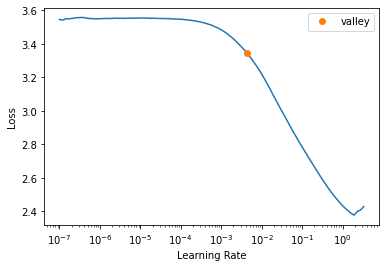

In [ ]:
lr = learn.lr_find()[0]
learn.fit_one_cycle(15, lr, wd=0.1) # Ojo que aqui tambien agregamos weight decay